In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD, Adam
import os
import matplotlib.pyplot as plt
import warnings
from pathlib import Path

import quantnn as q
os.environ['CUDA_VISIBLE_DEVICES'] = ''

from load_data import ConvertDatasetToNumpy, ComputeStatsFromNumpyFiles, GOESRETRIEVALSDataset, ToTensor, Standardize


In [2]:
class QuantileLoss:
    def __init__(self, quantiles):
        self.quantiles = quantiles
        
    def __call__(self, y_pred, y_true):
        return q.quantile_loss(y_pred, self.quantiles, y_true).mean()
        
        
class Net(nn.Module):
    def __init__(self, num_quantiles, num_channels, kernel_size):
        super(Net, self).__init__()
    
        self.c1 = nn.Conv2d(num_channels, 128, kernel_size)
        self.c2 = nn.Conv2d(128, 128, kernel_size)
        self.c3 = nn.Conv2d(128, num_quantiles, kernel_size)
        self.b = nn.BatchNorm2d(128)
    
    
    def forward(self, x):

        x = F.relu(self.b(self.c1(x)))
        
        for i in range(2):
            x = F.relu(self.b(self.c2(x)))
        
        x = self.c3(x)
        
        return x
        

def train(model, X, y, optimizer, criterion):
    model.zero_grad()
    output = model(X)
    #print(output)
    loss = criterion(output, y)
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
    loss.backward()
    optimizer.step()

    return loss

def plotRandomSample(train_dataset):
    X_train = [train_dataset[i]['box'] for i in range(len(train_dataset))]
    y_train = [train_dataset[i]['label'] for i in range(len(train_dataset))]

    from matplotlib.colors import LogNorm
    from matplotlib.gridspec import GridSpec

    f = plt.figure(figsize=(15, 6))
    gs =  GridSpec(2, 3, figure=f, height_ratios=[1.0, 0.1])
    index = np.random.randint(len(X_train))

    precip_norm = LogNorm(1e-2, 1e2)

    ax = plt.subplot(gs[0, 0])
    m = ax.imshow(X_train[index].numpy()[0])
    ax.grid(False)
    ax.set_title("(a) channel 8", loc="left")
    ax = plt.subplot(gs[1, 0])
    plt.colorbar(m, cax=ax, orientation="horizontal", label="Normalized brightness temperature")

    ax = plt.subplot(gs[0, 1])
    m = ax.imshow(X_train[index].numpy()[1])
    ax.grid(False)
    ax.set_title("(b) channel 13", loc="left")
    ax = plt.subplot(gs[1, 1])
    plt.colorbar(m, cax=ax, orientation="horizontal", label="Normalized brightness temperature")

    ax = plt.subplot(gs[0, 2])
    m = ax.imshow(y_train[index].numpy(), norm=precip_norm)
    ax.grid(False)
    ax.set_title("(c) Reference rain rate", loc="left")
    ax = plt.subplot(gs[1, 2])
    plt.colorbar(m, cax=ax, orientation="horizontal", label=r"Rain rate [mm/h]")

    plt.tight_layout()
    

In [3]:

channels = [8,13]

EPOCHS = 5
BATCH_SIZE = 2

#quantiles = [0.01, 0.05, 0.15, 0.25, 0.35, 0.45, 0.5, 0.55, 0.65, 0.75, 0.85, 0.95, 0.99]
quantiles = [0.01, 0.5, 0.99]

path_to_load_data = 'data/first_net_dataset/train/'
path_to_save_data = 'data/first_net_dataset/train/npy_files'
path_to_stats = os.path.join(Path(path_to_save_data).parent, Path('stats.npy'))

In [4]:
ConvertDatasetToNumpy(path_to_load_data = path_to_load_data,
                      path_to_save_data = path_to_save_data)

train_dataset = GOESRETRIEVALSDataset(
    path_to_data = path_to_save_data,
    channels = channels, 
    transform = transforms.Compose([Standardize(path_to_save_data, path_to_stats, channels), ToTensor()]),
    singles = False
)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

[[233.22173112 269.27052031]
 [  7.07067325  20.06164785]]


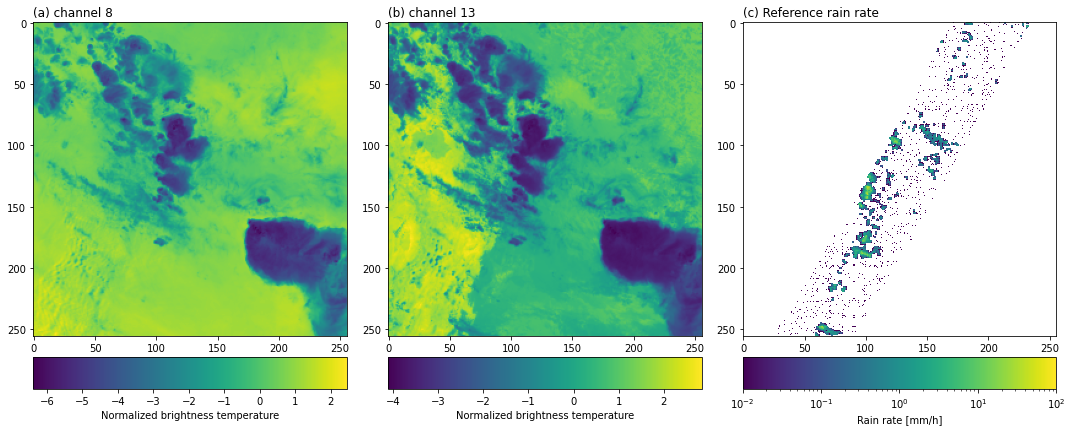

In [6]:
plotRandomSample(train_dataset)

In [7]:
net = Net(len(quantiles), len(channels), 1)

criterion = QuantileLoss(quantiles)
optimizer = SGD(net.parameters(), lr = 0.1)

In [ ]:

for epoch in range(EPOCHS):
    epoch_loss = 0
    for batch_index, batch in enumerate(train_dataloader):
        X = batch['box']
        y = batch['label']
        batch_loss = train(net, X, y, optimizer, criterion)
        print(batch_loss.item())
        epoch_loss += batch_loss.item()
        
    print(epoch, epoch_loss, 'average: ', epoch_loss/(batch_index+1))


In [ ]:
test_dataset = GOESRETRIEVALSDataset(
    path_to_data = 'data/first_net_dataset/test/',
    channels = channels)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
tot_loss = 0
for batch_index, batch in enumerate(test_dataloader):

    X = batch['box']
    y = batch['label']
    y = y.reshape(len(y), -1)
    output = net(X)
    batch_loss = criterion(output, y)

    tot_loss += batch_loss.item()

print(tot_loss, tot_loss, 'average: ', tot_loss/batch_index)


In [ ]:

outp = output.detach().numpy()
print(outp.shape)
yp = y.detach().numpy()
print(yp.shape)


i = int(outp.shape[1]/2)
print(i)
plt.scatter(yp, outp[:,i])
plt.show()